In [1]:
import os
import umap
import torch
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from Bio import SeqIO
from copy import deepcopy
from torch.optim import Adam
from tpot import TPOTRegressor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from IPython.display import Image
from qhoptim.pyt import QHM, QHAdam
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from scipy.stats import spearmanr, pearsonr
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: F

In [2]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.models import ApproximateGP, ExactGP 
from sklearn.metrics import accuracy_score
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from gpytorch.mlls import VariationalELBO, VariationalELBOEmpirical, DeepApproximateMLL
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP

In [4]:
transformer = get_Cas9_transformer(True)

In [5]:
%%bash

ls /home/bakirillov/HDD/data/CRISPR-CAD/Weissman/

41587_2019_387_MOESM3_ESM.zip
Table_S10_compact_library_sequences_revised.txt
Table_S11_compact_screen_phenotypes_revised.txt
Table_S12_compact_screen_sgRNA_counts_revised.txt
Table_S13_PS_gene_descriptions.xlsx
Table_S14_perturb_seq_cell_counts.txt
Table_S15_perturb-seq_screen_sgRNA_counts.txt
Table_S16_perturb-seq_screen_phenotypes.txt
Table_S17_oligonucleotide_sequences.xlsx
Table_S1_sgRNA_sequences.xlsx
Table_S2_large-scale_library_sequences_revised.txt
Table_S3_large-scale_screen_sgRNA_counts.txt
Table_S4_large-scale_screen_phenotypes.txt
Table_S5_constant_region_sequences.txt
Table_S6_constant_region_screen_sgRNA_counts.txt
Table_S7_constant_region_screen_phenotypes.txt
Table_S8_machine_learning_input.txt
Table_S9_genome-wide_predicted_activities_revised.txt.gz


In [6]:
s1seqs = pd.read_excel(
    "/home/bakirillov/HDD/data/CRISPR-CAD/Weissman/Table_S1_sgRNA_sequences.xlsx",
)

In [11]:
s1seqs["experiment"].unique()

array(['GFP single mismatches', 'constant region RT-qPCR',
       'constant region screen', 'perturb-seq'], dtype=object)

In [12]:
s1seqs[s1seqs["experiment"] == "GFP single mismatches"]

,experiment,name,sequence,target_gene
0,GFP single mismatches,EGFP-NT2,GACCAGGATGGGCACCACCC,EGFP


In [31]:
s1seqs[s1seqs["experiment"] == "GFP single mismatches"]["sequence"][0]

'GACCAGGATGGGCACCACCC'

In [13]:
s2seqs = pd.read_csv(
    "/home/bakirillov/HDD/data/CRISPR-CAD/Weissman/Table_S2_large-scale_library_sequences_revised.txt",
    sep="\t"
)

In [32]:
s5seqs = pd.read_csv(
    "/home/bakirillov/HDD/data/CRISPR-CAD/Weissman/Table_S5_constant_region_sequences.txt",
    sep="\t"
)
s6cnts = pd.read_csv(
    "/home/bakirillov/HDD/data/CRISPR-CAD/Weissman/Table_S6_constant_region_screen_sgRNA_counts.txt",
    sep="\t"
)
s7ph = pd.read_csv(
    "/home/bakirillov/HDD/data/CRISPR-CAD/Weissman/Table_S7_constant_region_screen_phenotypes.txt",
    sep="\t"
)

In [36]:
s7ph

,Unnamed: 0,Day4,Day4.1,Day4.2,Day6,Day6.1,Day6.2,Day8,Day8.1,Day8.2
0,NaN,gamma,gamma,gamma,gamma,gamma,gamma,gamma,gamma,gamma
1,NaN,Rep1,Rep2,ave_Rep1_Rep2,Rep1,Rep2,ave_Rep1_Rep2,Rep1,Rep2,ave_Rep1_Rep2
2,CAD_+_27440253.23-P1P2_cr001,-0.400064,-0.323203,-0.361634,-0.383568,-0.295126,-0.339347,-0.370479,-0.269196,-0.319837
3,CAD_+_27440253.23-P1P2_cr002,-0.059154,-0.059227,-0.059190,-0.035502,-0.039911,-0.037706,-0.045839,-0.046654,-0.046247
4,CAD_+_27440253.23-P1P2_cr003,0.035774,0.019272,0.027523,0.023570,-0.013333,0.005118,0.020506,0.009640,0.015073
5,CAD_+_27440253.23-P1P2_cr004,0.034205,-0.021559,0.006323,0.023626,-0.014141,0.004742,0.010589,-0.004172,0.003208
6,CAD_+_27440253.23-P1P2_cr005,-0.150065,-0.150766,-0.150415,-0.183270,-0.134973,-0.159121,-0.144287,-0.120969,-0.132628
7,CAD_+_27440253.23-P1P2_cr006,-0.008355,0.002116,-0.003120,0.006240,0.004322,0.005281,0.007376,0.019045,0.013211
8,CAD_+_27440253.23-P1P2_cr007,-0.022803,-0.031718,-0.027260,-0.010418,-0.010863,-0.010641,-0.011434,-0.013876,-0.012655
9,CAD_+_27440253.23-P1P2_cr008,-0.281243,-0.290966,-0.286104,-0.291573,-0.254003,-0.272788,-0.239334,-0.270130,-0.254732


In [43]:
s15seqs = pd.read_csv(
    "/home/bakirillov/HDD/data/CRISPR-CAD/Weissman/Table_S15_perturb-seq_screen_sgRNA_counts.txt",
    sep="\t"
)
s6cnts = pd.read_csv(
    "/home/bakirillov/HDD/data/CRISPR-CAD/Weissman/Table_S6_constant_region_screen_sgRNA_counts.txt",
    sep="\t"
)
s7ph = pd.read_csv(
    "/home/bakirillov/HDD/data/CRISPR-CAD/Weissman/Table_S7_constant_region_screen_phenotypes.txt",
    sep="\t"
)

In [44]:
s15seqs

,Unnamed: 0,T0,d10,d5
0,ALDOA_+_30077139.23-P1P2_00,5280,2781,4056
1,ALDOA_+_30077139.23-P1P2_06,6015,3500,4831
2,ALDOA_+_30077139.23-P1P2_07,4830,3028,4284
3,ALDOA_+_30077139.23-P1P2_13,6699,26890,16944
4,ALDOA_+_30077139.23-P1P2_14,3603,6076,5347
5,ATP5E_-_57607036.23-P1P2_00,8197,9475,12109
6,ATP5E_-_57607036.23-P1P2_01,7774,8806,10487
7,ATP5E_-_57607036.23-P1P2_04,7209,14860,13256
8,ATP5E_-_57607036.23-P1P2_14,4611,15257,10750
9,ATP5E_-_57607036.23-P1P2_16,6210,9964,9571


In [14]:
np.unique(cr["sequence"].apply(len))

array([87])

In [32]:
from Bio.SeqFeature import SeqFeature, FeatureLocation

In [33]:
def getCandidate(start, end):
    l = FeatureLocation(start, end)
    f = SeqFeature(l, strand=1, type="sgRNA")
    return(f)

In [42]:
for a in np.arange(len(cr["sequence"][0])):
    candidate = (a, getCandidate(int(a), int(a+23)))
    current = candidate[1].extract(cr["sequence"][0])
    if len(current) == 23 and current[-2:] == "GG":
        print(current)

CAGCATAGCAAGTTTAAATAAGG
CCGTTATCAACTTGAAAAAGTGG
TTGAAAAAGTGGCACCGAGTCGG


In [38]:
cr["sequence"][0][-2:]

'CT'

In [ ]:
for a in tqdm(np.arange(len(s))):
            candidate = (int(a), Logic.getCandidate(int(a), int(a)+length+plen))
            if re.search(pam_regex, get_pam(candidate[1], s, plen, length)):
                candidates.append(candidate)
        cut_pam = lambda x: x[plen:] if before else x[:-plen]
        guides = [(cut_pam(a[1].extract(s)), a[0], a[0]+length-1, get_pam(a[1], s, plen, length)) for a in candidates]

def getCandidate(start, end):
        l = FeatureLocation(start, end)
        f = SeqFeature(l, strand=1, type="sgRNA")
        return(f)

In [17]:
cr["sequence"]

0      ATTTAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
1      CTTTAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
2      TTTTAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
3      GATTAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
4      GCTTAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
5      GGTTAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
6      GTATAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
7      GTCTAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
8      GTGTAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
9      GTTAAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
10     GTTCAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
11     GTTGAAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
12     GTTTGAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
13     GTTTCAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
14     GTTTACGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
15     GTTTATGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
16     GTTTAGGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAATAAGGCT...
17     GTTTAAAAGCTAAGCTGGAAACAG

In [23]:
from weblogolib import *

In [25]:
with open("test.fa", "w") as oh:
    for a in s5seqs["sequence"].values:
        oh.write(">\n"+a+"\n")

In [26]:
fin = open("test.fa")
seqs = read_seq_data(fin)

In [27]:
logodata = LogoData.from_seqs(seqs)

In [28]:
logooptions = LogoOptions()
logooptions.title = "Most Active Cluster Logo"
logoformat = LogoFormat(logodata, logooptions)

In [29]:
png = png_formatter(logodata, logoformat)

In [30]:
with open("logo.png", "wb") as oh:
    oh.write(png)

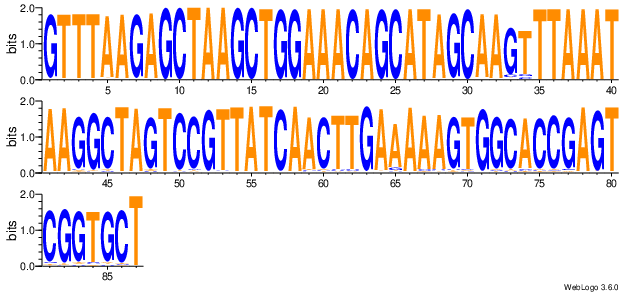

In [31]:
Image("logo.png")

In [8]:
chr22 = SeqIO.parse("/home/bakirillov/HDD/data/genomes/chr22.fa", "fasta")
chr22 = [a for a in chr22][0]

In [9]:
TEMPLATE = "/home/bakirillov/HDD/data/chr22_genes/GENE\nNNNNNNNNNNNNNNNNNNNNNGG\nNNNNNNNNNNNNNNNNNNNNNGG 0\n"
COMMAND = "/home/bakirillov/HDD/apps/cas-offinder CONFIG G OUTPUT"

In [10]:
if not op.exists("/home/bakirillov/HDD/data/chr22_genes/"):
    os.makedirs("/home/bakirillov/HDD/data/chr22_genes/")
if not op.exists("/home/bakirillov/HDD/data/chr22_grnas/"):
    os.makedirs("/home/bakirillov/HDD/data/chr22_grnas/")
if not op.exists("/home/bakirillov/HDD/data/chr22_casoffinder_configs/"):
    os.makedirs("/home/bakirillov/HDD/data/chr22_casoffinder_configs/")

In [11]:
script = open("run_casoffinder.sh", "w")
script.write("#!/bin/sh\n\n")
for start, stop, gene in tqdm(annotation):
    with open("/home/bakirillov/HDD/data/chr22_genes/"+gene+".fa", "w") as oh:
        oh.write(">"+gene+"\n")
        oh.write(str(chr22.seq[start:stop]))
    with open("/home/bakirillov/HDD/data/chr22_casoffinder_configs/"+gene+".txt", "w") as oh:
        oh.write(TEMPLATE.replace("GENE", gene+".fa"))
    script.write(
        COMMAND.replace(
            "CONFIG", "/home/bakirillov/HDD/data/chr22_casoffinder_configs/"+gene+".txt"
        ).replace(
            "OUTPUT", "/home/bakirillov/HDD/data/chr22_grnas/"+gene+".tsv"
        )+"\n"
    )
script.close()

100%|██████████| 1186/1186 [00:00<00:00, 1550.43it/s]


In [12]:
cnn_mse_encoder = GuideHN(21, 32, 1360, n_classes=5).cuda()
cnn_mse = DKL(cnn_mse_encoder, [1,5*32]).cuda()
cnn_mse.load_state_dict(torch.load("../models/DeepHF/Wt/cnn_mse59.ptch"))
cnn_mse = cnn_mse.eval()

In [13]:
rnn_mse_encoder = GuideHRNN(21, 32, 3360, n_classes=5).cuda()
rnn_mse = DKL(rnn_mse_encoder, [1,5*32]).cuda()
rnn_mse.load_state_dict(torch.load("../models/DeepHF/Wt/rnn_mse59.ptch"))
rnn_mse = rnn_mse.eval()

In [14]:
cnn_elbo_encoder = GuideHN(21, 32, 1360, n_classes=5).cuda()
cnn_elbo = DKL(cnn_elbo_encoder, [1,5*32]).cuda()
cnn_elbo.load_state_dict(torch.load("../models/DeepHF/Wt/cnn_elbo59.ptch"))
cnn_elbo = cnn_elbo.eval()

In [15]:
rnn_elbo_encoder = GuideHRNN(21, 32, 3360, n_classes=5).cuda()
rnn_elbo = DKL(rnn_elbo_encoder, [1,5*32]).cuda()
rnn_elbo.load_state_dict(torch.load("../models/DeepHF/Wt/rnn_elbo59.ptch"))
rnn_elbo = rnn_elbo.eval()

In [16]:
data = np.array(
    [a for a in os.walk("/home/bakirillov/HDD/data/chr22_grnas/")][0][2]
)

In [17]:
sizes = np.array(
    [op.getsize(op.join("/home/bakirillov/HDD/data/chr22_grnas", a)) for a in data]
)

In [18]:
data[np.random.choice(np.arange(len(data)))]

'LOC101927202.tsv'

In [19]:
current_df = pd.read_csv(
    op.join(
        "/home/bakirillov/HDD/data/chr22_grnas/LOC440792.tsv"
    ), sep="\t", header=None
).dropna()
current_df = current_df[current_df[3].apply(lambda x: len(x) == 23)]
tds = DeepHFDataset(
    current_df, np.arange(current_df.shape[0]), transformer, sequence_column=3, 
    label_column=5
)
tld = DataLoader(tds, shuffle=False, batch_size=256)
tb_cnn_mse_oa = []
tb_cnn_mse_va = []
tb_cnn_mse_ra = []
tb_rnn_mse_oa = []
tb_rnn_mse_va = []
tb_rnn_mse_ra = []
tb_cnn_elbo_oa = []
tb_cnn_elbo_va = []
tb_cnn_elbo_ra = []
tb_rnn_elbo_oa = []
tb_rnn_elbo_va = []
tb_rnn_elbo_ra = []
for transformed_batch, _ in tqdm(tld):
    tb_cnn_mse_o = cnn_mse_encoder(transformed_batch)[0].cpu().data.numpy()
    tb_cnn_mse_ra.extend(tb_cnn_mse_o)
    tb_rnn_mse_o = rnn_mse_encoder(transformed_batch)[0].cpu().data.numpy()
    tb_rnn_mse_ra.extend(tb_rnn_mse_o)
    tb_cnn_elbo_o = cnn_elbo_encoder(transformed_batch)[0].cpu().data.numpy()
    tb_cnn_elbo_ra.extend(tb_cnn_elbo_o)
    tb_rnn_elbo_o = rnn_elbo_encoder(transformed_batch)[0].cpu().data.numpy()
    tb_rnn_elbo_ra.extend(tb_rnn_elbo_o)
    tb_cnn_mse = cnn_mse(transformed_batch)
    tb_cnn_mse_o = cnn_mse.likelihood(
        tb_cnn_mse[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_cnn_mse_v = cnn_mse.likelihood(
        tb_cnn_mse[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_cnn_mse_oa.extend(tb_cnn_mse_o)
    tb_cnn_mse_va.extend(tb_cnn_mse_v)
    tb_rnn_mse = rnn_mse(transformed_batch)
    tb_rnn_mse_o = rnn_mse.likelihood(
        tb_rnn_mse[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_rnn_mse_v = rnn_mse.likelihood(
        tb_rnn_mse[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_rnn_mse_oa.extend(tb_rnn_mse_o)
    tb_rnn_mse_va.extend(tb_rnn_mse_v)
    tb_cnn_elbo = cnn_elbo(transformed_batch)
    tb_cnn_elbo_o = cnn_elbo.likelihood(
        tb_cnn_elbo[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_cnn_elbo_v = cnn_elbo.likelihood(
        tb_cnn_elbo[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_cnn_elbo_oa.extend(tb_cnn_elbo_o)
    tb_cnn_elbo_va.extend(tb_cnn_elbo_v)
    tb_rnn_elbo = rnn_elbo(transformed_batch)
    tb_rnn_elbo_o = rnn_elbo.likelihood(
        tb_rnn_elbo[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_rnn_elbo_v = rnn_elbo.likelihood(
        tb_rnn_elbo[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_rnn_elbo_oa.extend(tb_rnn_elbo_o)
    tb_rnn_elbo_va.extend(tb_rnn_elbo_v)

100%|██████████| 11/11 [00:02<00:00,  5.23it/s]


In [20]:
tb_cnn_mse_ra = np.stack(tb_cnn_mse_ra).reshape(-1, 5*32)
tb_rnn_mse_ra = np.stack(tb_rnn_mse_ra).reshape(-1, 5*32)
tb_cnn_elbo_ra = np.stack(tb_cnn_elbo_ra).reshape(-1, 5*32)
tb_rnn_elbo_ra = np.stack(tb_rnn_elbo_ra).reshape(-1, 5*32)

In [21]:
uvis_cm = umap.UMAP()
uvis_cm.fit(tb_cnn_mse_ra)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

In [22]:
from sklearn.decomposition import PCA

In [23]:
pvis_cm = PCA()
pv_cm = pvis_cm.fit_transform(tb_cnn_mse_ra)

In [24]:
import ncvis

In [25]:
nvis_cm = ncvis.NCVis()
nv_cm = nvis_cm.fit_transform(tb_cnn_mse_ra)

In [26]:
import hdbscan

In [39]:
clustering = hdbscan.HDBSCAN(min_cluster_size=10)
clusters = clustering.fit_predict(nv_cm)

In [144]:
from sklearn.cluster import AgglomerativeClustering

In [164]:
clustering = AgglomerativeClustering(distance_threshold=5, n_clusters=None)
clusters = clustering.fit_predict(nv_cm)

In [165]:
np.unique(clusters, return_counts = True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

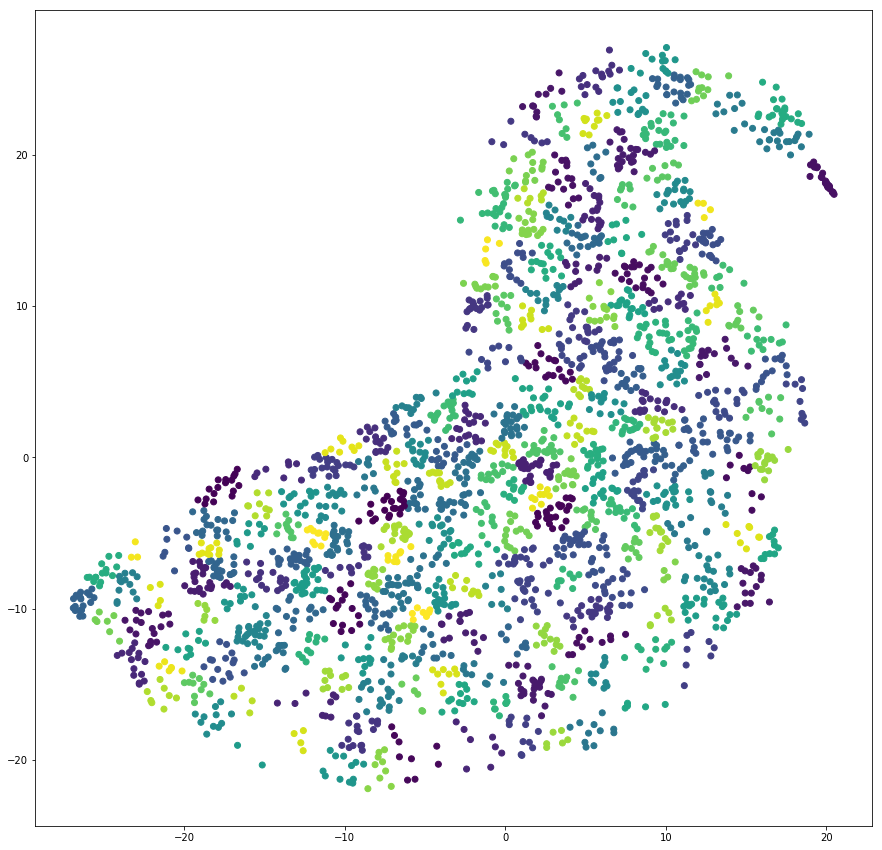

In [166]:
plt.scatter(nv_cm.T[0], nv_cm.T[1], c=clusters)

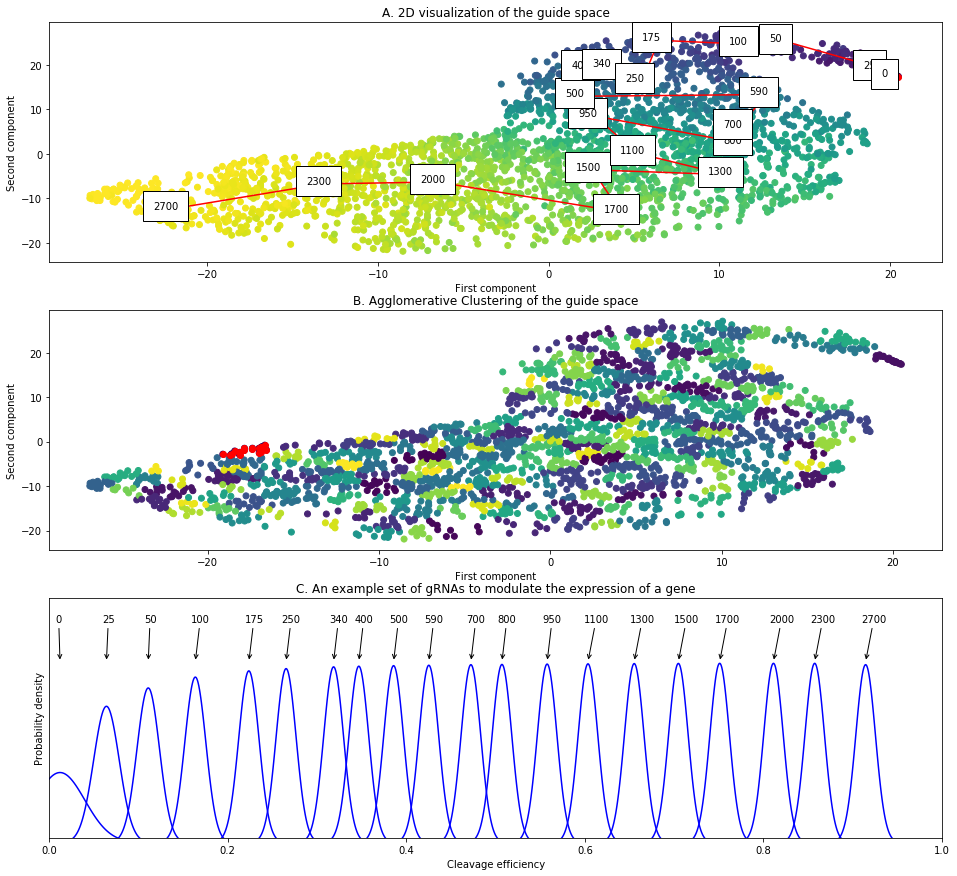

In [194]:
from matplotlib import rcParams

rcParams["figure.figsize"] = (16, 15)
numbers = [0, 25, 50, 100, 175, 250, 340, 400, 500, 590, 700, 800, 950,1100,1300,1500,1700,2000,2300,2700]
tb_cnn_mse_oa_o = np.array(sorted(tb_cnn_mse_oa))
tb_cnn_mse_va = np.array(tb_cnn_mse_va)
mus = [tb_cnn_mse_oa_o[a] for a in numbers]
sigmas = [tb_cnn_mse_va[tb_cnn_mse_oa == a] for a in mus]
Xs = [nv_cm.T[0][tb_cnn_mse_oa == a] for a in mus]
Ys = [nv_cm.T[1][tb_cnn_mse_oa == a] for a in mus]
top20 = np.arange(tb_cnn_mse_oa_o.shape[0])[clusters == 1]
Xs_top20 = [nv_cm.T[0][a] for a in top20]
Ys_top20 = [nv_cm.T[1][a] for a in top20]
plt.subplot(3, 1, 1)
plt.scatter(nv_cm.T[0], nv_cm.T[1], c=tb_cnn_mse_oa)
plt.scatter(Xs, Ys, color="red")
plt.plot(Xs, Ys, color="red")
plt.title("A. 2D visualization of the guide space")
for a,b,num in list(reversed(list(zip(Xs, Ys, numbers)))):
    plt.annotate(
        str(num), xy=(a-1,b), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
plt.xlabel("First component")
plt.ylabel("Second component")
from scipy import stats
plt.subplot(3,1,2)
plt.scatter(nv_cm.T[0], nv_cm.T[1], c=clusters)
plt.scatter(Xs_top20, Ys_top20, color="red")
plt.title("B. Agglomerative Clustering of the guide space")
plt.xlabel("First component")
plt.ylabel("Second component")
plt.subplot(3,1,3)
for mu, sigma, num in zip(mus, sigmas, numbers):
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color="blue")
    plt.annotate(
        str(num), xy=(mu,37), xytext=(mu-0.005, 45), 
        arrowprops=dict(facecolor='black', arrowstyle="->"),
    )
plt.xlim((0,1))
plt.ylim((1,50))
plt.yticks([])
plt.xlabel("Cleavage efficiency")
plt.ylabel("Probability density")
plt.title("C. An example set of gRNAs to modulate the expression of a gene")
plt.show()

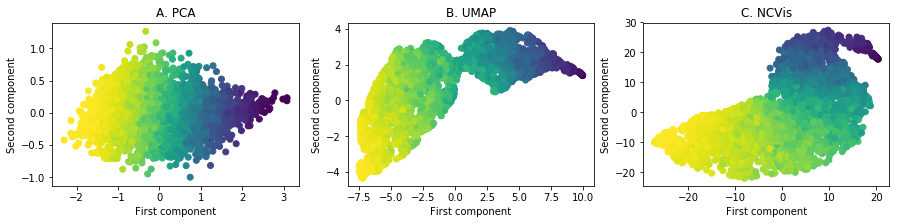

In [31]:
from matplotlib.patches import Patch
from matplotlib.pyplot import rcParams

rcParams["figure.figsize"] = (15, 3)
data1 = np.random.normal(size=100)
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].scatter(pv_cm.T[0], pv_cm.T[1], c=tb_cnn_mse_oa)
ax[0].set_title("A. PCA")
ax[0].set_xlabel("First component")
ax[0].set_ylabel("Second component")
ax[1].scatter(uvis_cm.embedding_.T[0], uvis_cm.embedding_.T[1], c=tb_cnn_mse_oa)
ax[1].set_title("B. UMAP")
ax[1].set_xlabel("First component")
ax[1].set_ylabel("Second component")
ax[2].scatter(nv_cm.T[0], nv_cm.T[1], c=tb_cnn_mse_oa)
ax[2].set_title("C. NCVis")
ax[2].set_xlabel("First component")
ax[2].set_ylabel("Second component")
plt.show()